## Latent Integration Network (LIN)
This notebook gives an example of how to train a LIN on SVD vectors. Note: 05_experiment_SVD.ipynb created and saved the SVD Decomposition. 

## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.mantaflowDatasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, reconFrame

#from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

from surrogates4sims.svd import MantaFlowSVDDataset

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_manta_SVD_MLP"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 
SVDFn = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/svd.pkl'
svd_vec_file = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/mantaSVDvecs.pkl'
FakeData = False

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 1

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 64
numSamplesToKeep = np.infty #if not debugging
latentDim = 512
simLen = 200

w = 30
numComponents = 16 # this does not include p. so the vectors will be of size numComponents + len(p)
hiddenLayers = [128,128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.Tanh()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}'.format(w,numComponents,hd,bz,epochs)
versionName

'LIN_manta_SVD_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000'

## Select Personal GPUs

In [ ]:
!nvidia-smi

Mon Oct 12 18:08:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   29C    P2    60W / 250W |    547MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 17%   25C    P0    55W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Mon Oct 12 18:08:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   29C    P2    60W / 250W |    547MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 17%   25C    P0    55W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Build Latent Vectors (Warning....)
The computation of building the latent vectors takes a loooong time. 
This codes checks to see if svd_vec_file has been saved. If it has, 
it will reload them. 

In [ ]:
if FakeData:
    numTrainSamps = 100
    numTestSamps = 10
    simLen
    A = np.random.randn(numComponents,numComponents)
    A = A/np.linalg.norm(A)
    p = np.random.randn(simLen,3).astype('float32')
    def makeSample(A,p,simLen=200):
        x = np.random.randn(numComponents,)
        X = [x.copy()]
        for i in range(simLen):
            x = np.matmul(A,x)
            X.append(x.copy())
        #p = np.zeros((simLen,3)).astype('float32')
        X = np.array(X).astype('float32')
        return X[:simLen], p

    train_data = []
    for i in range(numTrainSamps):
        train_data.append(makeSample(A,p))
    #train_data = np.array(train_data)
    
    test_data = []
    for i in range(numTestSamps):
        test_data.append(makeSample(A,p))
    #test_data = np.array(test_data)
    
else:
    if os.path.exists(svd_vec_file):
        data = pkl_load(svd_vec_file)
        train_data = data['train_data']
        test_data = data['test_data']
    else:
        svd_data = pkl_load(SVDFn)
        print(svd_data.keys())

        svd_vecs = svd_data['spatialVecs'][:,:numComponents]
        print(svd_vecs.shape)

        trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
        print((len(trainData),len(testData)))

        def createSVDdataset(trainData):

            # datasets may be smaller because: numSamplesToKeep 
            # Be careful the default is for the data to be preprocessed. Therefore, we have to invPrecprocess if 
            # we are looking at relative errors. 
            trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
            trainDataLoader = DataLoader(dataset=trainDataset, batch_size=len(trainDataset))
            X_train,p_train = next(iter(trainDataLoader))
            print(X_train.shape, p_train.shape)
            z_train = list(map(lambda x: reconFrame(svd_vecs, x, numComponents),X_train.numpy()))

            train_recons, latent_vec_train = zip(*z_train)
            train_recons = np.array(train_recons)
            latent_vec_train = np.array(latent_vec_train)

            v = np.arange(0,len(latent_vec_train),simLen)

            sims = []
            for idx in v:
                sims.append((latent_vec_train[idx:idx+simLen],p_train[idx:idx+simLen]))
            sims = np.array(sims)
            print('num_sims {}'.format(len(sims)))
            return sims

        train_data = createSVDdataset(trainData)
        test_data = createSVDdataset(testData)
        D = {'train_data':train_data,'test_data':test_data}
        pkl_save(D,svd_vec_file)

In [ ]:
train_data[0][0].shape, train_data[0][1].shape

((200, 16), (200, 3))

In [ ]:
# reduce the dimensions of z down to the numComponents 
for idx,d in enumerate(train_data):
    X = d[0][:,:numComponents]
    p = d[1]
    train_data[idx] = (X,p)
    
for idx,d in enumerate(test_data):
    X = d[0][:,:numComponents]
    p = d[1]
    test_data[idx] = (X,p)

## Investigate how to preprocess the data

In [ ]:
len(train_data), len(test_data)

(100, 10)

In [ ]:
D = []
for d in train_data:
    D.append(np.hstack(d))
D = np.vstack(D)
D.shape

(20000, 19)

In [ ]:
D.max()

3.678587

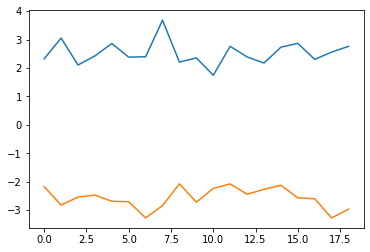

In [ ]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.show()

## Dataset and Dataloader

In [ ]:
class LatentVectors(Dataset):
    def __init__(self, data,doPreprocess=False,w=1,simLen=200,mx=x_mx,mn=x_mn):
        self.data = data
        self.doPreprocess = doPreprocess
        self.simLen = simLen
        self.w = w
        self.mx = mx
        self.mn = mn
                 
    def __len__(self):
        return self.simLen*len(self.data)

    def preprocess(self,x):
        xnew = 2*((x-self.mn)/(self.mx-self.mn) - .5)
        return xnew

    def invPreprocess(self,xnew):
        x = ((xnew/2)+.5)*(self.mx-self.mn) + self.mn
        return x
    
    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        X,p = self.data[q]
        r_idx = np.random.randint(0,self.simLen-self.w)
        x = np.hstack([X[r_idx:r_idx+1],p[r_idx:r_idx+1]])
        #print(x.shape)
        y = np.hstack([X[r_idx+1:r_idx+self.w+1],p[r_idx+1:r_idx+self.w+1]])
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocess(x)
            y = self.preprocess(y)
        return x, y

In [ ]:
trainDataset = LatentVectors(train_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)
testDataset = LatentVectors(test_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)

In [ ]:
X,y = trainDataset[4]
X.shape,y.shape

((1, 19), (30, 19))

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(20000, 312, 2000, 32)

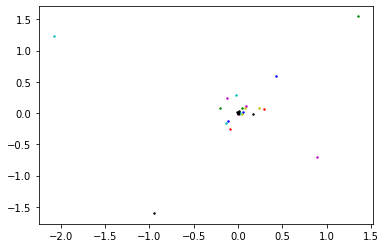

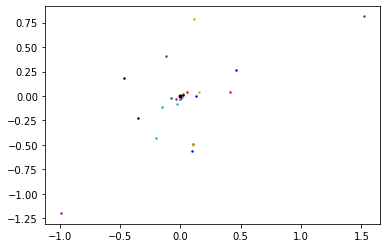

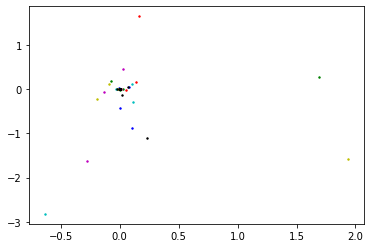

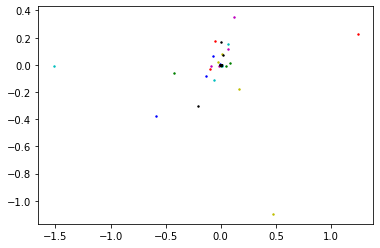

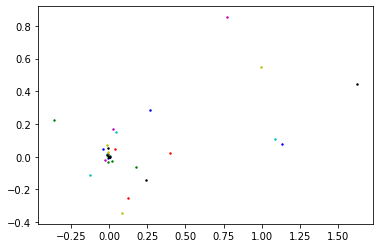

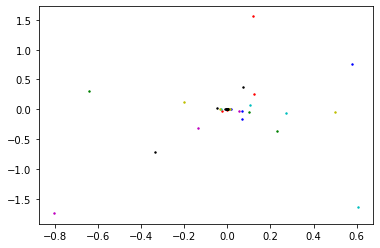

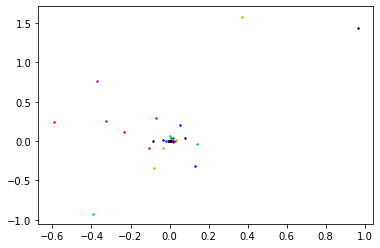

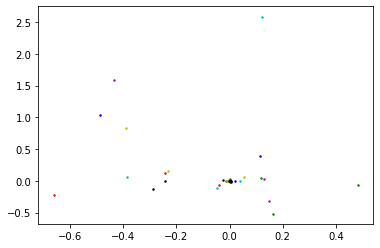

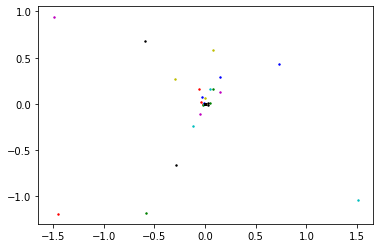

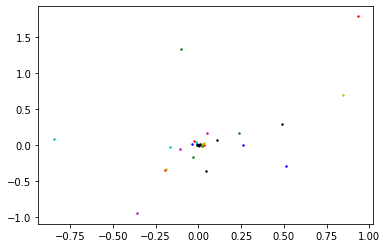

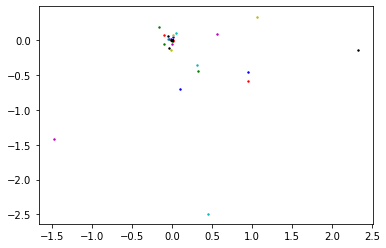

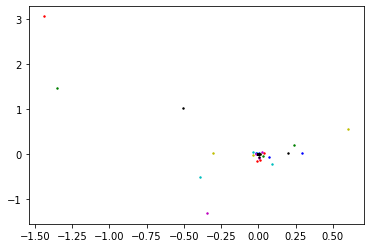

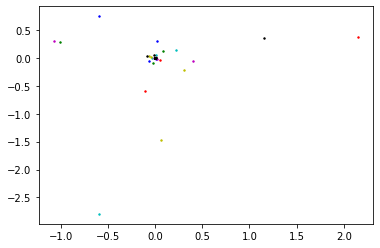

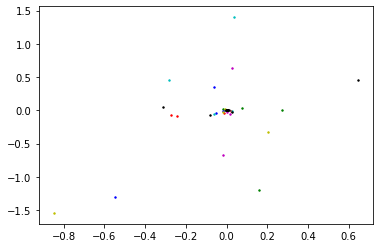

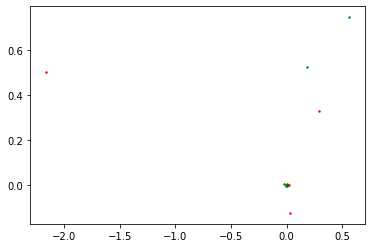

In [ ]:
# plot the first 2 coordinates of the first 3 simulations
# this makes me think that this is going to be a hard problem. 
Dplot = D.reshape(len(train_data),simLen,-1)
colors = ['r','g','b','c','m','y','k']
nc = len(colors)
for sim in range(0,len(train_data),nc):
    A = Dplot[sim:sim+nc]
    for idx, x in enumerate(A):
        plt.scatter(x[:,0],x[:,1],c=colors[idx],s=2)
    plt.show()

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([64, 1, 19]), torch.Size([64, 30, 19]))

In [ ]:
model = MLP(X, hiddenLayerSizes=hiddenLayers,activation=activation)
model

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
output = model(X)
output.shape

torch.Size([64, 1, 19])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

6 layers require gradients (unfrozen) out of 6 layers
21,523 parameters require gradients (unfrozen) out of 21,523 parameters


## Loss Function

In [ ]:
L = nn.MSELoss()

In [ ]:
L(output,y[:,0:1,:])

tensor(0.0366, grad_fn=<MseLossBackward>)

In [ ]:
sum_loss = 0
out = X.clone()
for idx in range(w):
    out = model(out).clone()
    sum_loss += L(out,y[:,idx:idx+1,:])
sum_loss

tensor(0.9860, grad_fn=<AddBackward0>)

In [ ]:
combined_loss = L(output,y)
combined_loss.backward()

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



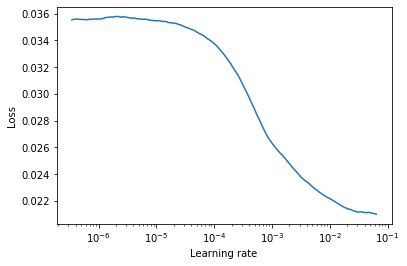

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)


In [ ]:
max_lr = .001
opt = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

In [ ]:
versionName

'LIN_manta_SVD_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000_lr0.001'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        combined_loss = 0.
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = X.clone()
        predictions = []
        for w_idx in range(w):
            y_hat = model(y_hat).clone()
            y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
            predictions.append(y_hat)
            combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        combined_loss = 0.
        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = X.clone()
            predictions = []
            for w_idx in range(w):
                y_hat = model(y_hat).clone()
                y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
                predictions.append(y_hat)
                combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])

        running_loss += combined_loss.item()

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

    avg_running_loss = running_loss/len(myDataLoader)
    avg_running_rmse = running_rmse/len(myDataLoader)
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return avg_running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
model = model.to(device)
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, L,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
    if trainLoss < bestLoss:
        bestLoss = trainLoss
        writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    #checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    #lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)



  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 3.5544e-03
LR: 1.0000e-03
Better trainLoss: 3.5544e-03, Saving models...




  0%|          | 1/1000 [00:11<3:14:01, 11.65s/it]

valLoss: 8.8249e-05
Better valLoss: 8.8249e-05, Saving models...
--- Epoch 2/1000 ---
trainLoss: 7.2250e-05
LR: 1.0000e-03
Better trainLoss: 7.2250e-05, Saving models...




  0%|          | 2/1000 [00:22<3:10:53, 11.48s/it]

valLoss: 7.2371e-05
--- Epoch 3/1000 ---
trainLoss: 5.4795e-05
LR: 1.0000e-03
Better trainLoss: 5.4795e-05, Saving models...




  0%|          | 3/1000 [00:34<3:10:15, 11.45s/it]

valLoss: 4.8908e-05
Better valLoss: 4.8908e-05, Saving models...
--- Epoch 4/1000 ---
trainLoss: 4.5670e-05
LR: 1.0000e-03
Better trainLoss: 4.5670e-05, Saving models...




  0%|          | 4/1000 [00:45<3:08:56, 11.38s/it]

valLoss: 3.3268e-05
Better valLoss: 3.3268e-05, Saving models...
--- Epoch 5/1000 ---
trainLoss: 3.2007e-05
LR: 1.0000e-03
Better trainLoss: 3.2007e-05, Saving models...




  0%|          | 5/1000 [00:57<3:10:53, 11.51s/it]

valLoss: 2.5909e-05
Better valLoss: 2.5909e-05, Saving models...
--- Epoch 6/1000 ---
trainLoss: 2.3230e-05
LR: 1.0000e-03
Better trainLoss: 2.3230e-05, Saving models...




  1%|          | 6/1000 [01:08<3:09:44, 11.45s/it]

valLoss: 1.4185e-05
Better valLoss: 1.4185e-05, Saving models...
--- Epoch 7/1000 ---
trainLoss: 2.0404e-05
LR: 1.0000e-03




  1%|          | 7/1000 [01:19<3:06:21, 11.26s/it]

valLoss: 1.7985e-05
--- Epoch 8/1000 ---
trainLoss: 2.3415e-05
LR: 1.0000e-03




  1%|          | 8/1000 [01:30<3:08:02, 11.37s/it]

valLoss: 9.9071e-06
Better valLoss: 9.9071e-06, Saving models...
--- Epoch 9/1000 ---
trainLoss: 1.7234e-05
LR: 1.0000e-03




  1%|          | 9/1000 [01:42<3:06:29, 11.29s/it]

valLoss: 8.7660e-06
Better valLoss: 8.7660e-06, Saving models...
--- Epoch 10/1000 ---
trainLoss: 1.7060e-05
LR: 1.0000e-03




  1%|          | 10/1000 [01:53<3:06:16, 11.29s/it]

valLoss: 1.4635e-05
--- Epoch 11/1000 ---
trainLoss: 2.0531e-05
LR: 1.0000e-03




  1%|          | 11/1000 [02:05<3:09:20, 11.49s/it]

valLoss: 8.1950e-06
Better valLoss: 8.1950e-06, Saving models...
--- Epoch 12/1000 ---
trainLoss: 1.5993e-05
LR: 1.0000e-03




  1%|          | 12/1000 [02:16<3:09:26, 11.50s/it]

valLoss: 2.6297e-05
--- Epoch 13/1000 ---
trainLoss: 1.8140e-05
LR: 1.0000e-03




  1%|▏         | 13/1000 [02:27<3:04:58, 11.24s/it]

valLoss: 5.3290e-06
Better valLoss: 5.3290e-06, Saving models...
--- Epoch 14/1000 ---
trainLoss: 1.6089e-05
LR: 1.0000e-03




  1%|▏         | 14/1000 [02:38<3:04:53, 11.25s/it]

valLoss: 1.2988e-05
--- Epoch 15/1000 ---
trainLoss: 2.5573e-06
LR: 1.0000e-04
Better trainLoss: 2.5573e-06, Saving models...




  2%|▏         | 15/1000 [02:51<3:10:02, 11.58s/it]

valLoss: 1.7490e-06
Better valLoss: 1.7490e-06, Saving models...
--- Epoch 16/1000 ---
trainLoss: 2.0936e-06
LR: 1.0000e-04




  2%|▏         | 16/1000 [03:02<3:09:16, 11.54s/it]

valLoss: 2.2550e-06
--- Epoch 17/1000 ---
trainLoss: 1.9453e-06
LR: 1.0000e-04




  2%|▏         | 17/1000 [03:13<3:06:34, 11.39s/it]

valLoss: 1.9737e-06
--- Epoch 18/1000 ---
trainLoss: 1.6587e-06
LR: 1.0000e-04
Better trainLoss: 1.6587e-06, Saving models...




  2%|▏         | 18/1000 [03:24<3:06:09, 11.37s/it]

valLoss: 2.0181e-06
--- Epoch 19/1000 ---
trainLoss: 1.8631e-06
LR: 1.0000e-04




  2%|▏         | 19/1000 [03:36<3:08:35, 11.53s/it]

valLoss: 1.8958e-06
--- Epoch 20/1000 ---
trainLoss: 1.6750e-06
LR: 1.0000e-04




  2%|▏         | 20/1000 [03:48<3:09:43, 11.62s/it]

valLoss: 1.4793e-06
Better valLoss: 1.4793e-06, Saving models...
--- Epoch 21/1000 ---
trainLoss: 1.4219e-06
LR: 1.0000e-05
Better trainLoss: 1.4219e-06, Saving models...




  2%|▏         | 21/1000 [04:00<3:09:20, 11.60s/it]

valLoss: 1.5582e-06
--- Epoch 22/1000 ---
trainLoss: 1.5325e-06
LR: 1.0000e-05




  2%|▏         | 22/1000 [04:11<3:06:57, 11.47s/it]

valLoss: 1.8506e-06
--- Epoch 23/1000 ---
trainLoss: 1.3985e-06
LR: 1.0000e-05
Better trainLoss: 1.3985e-06, Saving models...




  2%|▏         | 23/1000 [04:22<3:06:00, 11.42s/it]

valLoss: 2.1576e-06
--- Epoch 24/1000 ---
trainLoss: 1.5918e-06
LR: 1.0000e-05




  2%|▏         | 24/1000 [04:33<3:02:43, 11.23s/it]

valLoss: 1.6301e-06
--- Epoch 25/1000 ---
trainLoss: 1.3670e-06
LR: 1.0000e-05
Better trainLoss: 1.3670e-06, Saving models...




  2%|▎         | 25/1000 [04:44<3:01:53, 11.19s/it]

valLoss: 1.3153e-06
Better valLoss: 1.3153e-06, Saving models...
--- Epoch 26/1000 ---
trainLoss: 1.4973e-06
LR: 1.0000e-05




  3%|▎         | 26/1000 [04:55<3:00:45, 11.14s/it]

valLoss: 1.5794e-06
--- Epoch 27/1000 ---
trainLoss: 1.3591e-06
LR: 1.0000e-05




  3%|▎         | 27/1000 [05:06<3:01:57, 11.22s/it]

valLoss: 1.4519e-06
--- Epoch 28/1000 ---
trainLoss: 1.4763e-06
LR: 1.0000e-05




  3%|▎         | 28/1000 [05:18<3:02:17, 11.25s/it]

valLoss: 1.3873e-06
--- Epoch 29/1000 ---
trainLoss: 1.2635e-06
LR: 1.0000e-05
Better trainLoss: 1.2635e-06, Saving models...




  3%|▎         | 29/1000 [05:29<2:59:51, 11.11s/it]

valLoss: 1.3348e-06
--- Epoch 30/1000 ---
trainLoss: 1.2532e-06
LR: 1.0000e-05
Better trainLoss: 1.2532e-06, Saving models...




  3%|▎         | 30/1000 [05:40<3:00:43, 11.18s/it]

valLoss: 1.1287e-06
Better valLoss: 1.1287e-06, Saving models...
--- Epoch 31/1000 ---
trainLoss: 1.2304e-06
LR: 1.0000e-05




  3%|▎         | 31/1000 [05:52<3:03:55, 11.39s/it]

valLoss: 1.5727e-06
--- Epoch 32/1000 ---
trainLoss: 1.1270e-06
LR: 1.0000e-05
Better trainLoss: 1.1270e-06, Saving models...




  3%|▎         | 32/1000 [06:03<3:03:35, 11.38s/it]

valLoss: 1.2651e-06
--- Epoch 33/1000 ---
trainLoss: 1.0740e-06
LR: 1.0000e-05
Better trainLoss: 1.0740e-06, Saving models...




  3%|▎         | 33/1000 [06:14<3:02:21, 11.32s/it]

valLoss: 1.3681e-06
--- Epoch 34/1000 ---
trainLoss: 1.1207e-06
LR: 1.0000e-05




  3%|▎         | 34/1000 [06:25<2:59:09, 11.13s/it]

valLoss: 9.4379e-07
Better valLoss: 9.4379e-07, Saving models...
--- Epoch 35/1000 ---
trainLoss: 1.0540e-06
LR: 1.0000e-05




  4%|▎         | 35/1000 [06:36<2:59:48, 11.18s/it]

valLoss: 7.9787e-07
Better valLoss: 7.9787e-07, Saving models...
--- Epoch 36/1000 ---
trainLoss: 1.0570e-06
LR: 1.0000e-05




  4%|▎         | 36/1000 [06:47<2:58:33, 11.11s/it]

valLoss: 9.9018e-07
--- Epoch 37/1000 ---
trainLoss: 9.2699e-07
LR: 1.0000e-05




  4%|▎         | 37/1000 [06:58<2:57:45, 11.08s/it]

valLoss: 9.0640e-07
--- Epoch 38/1000 ---
trainLoss: 8.6600e-07
LR: 1.0000e-05




  4%|▍         | 38/1000 [07:09<2:56:44, 11.02s/it]

valLoss: 9.6829e-07
--- Epoch 39/1000 ---
trainLoss: 9.2590e-07
LR: 1.0000e-05




  4%|▍         | 39/1000 [07:21<2:58:16, 11.13s/it]

valLoss: 8.6774e-07
--- Epoch 40/1000 ---
trainLoss: 8.3433e-07
LR: 1.0000e-05




  4%|▍         | 40/1000 [07:31<2:55:34, 10.97s/it]

valLoss: 8.8194e-07
--- Epoch 41/1000 ---
trainLoss: 7.5269e-07
LR: 1.0000e-05
Better trainLoss: 7.5269e-07, Saving models...




  4%|▍         | 41/1000 [07:42<2:56:41, 11.06s/it]

valLoss: 8.0229e-07
--- Epoch 42/1000 ---
trainLoss: 7.7228e-07
LR: 1.0000e-05




  4%|▍         | 42/1000 [07:53<2:56:54, 11.08s/it]

valLoss: 6.7854e-07
Better valLoss: 6.7854e-07, Saving models...
--- Epoch 43/1000 ---
trainLoss: 6.8923e-07
LR: 1.0000e-05




  4%|▍         | 43/1000 [08:05<2:58:02, 11.16s/it]

valLoss: 6.0734e-07
Better valLoss: 6.0734e-07, Saving models...
--- Epoch 44/1000 ---
trainLoss: 6.4898e-07
LR: 1.0000e-05




  4%|▍         | 44/1000 [08:16<2:56:37, 11.09s/it]

valLoss: 6.0731e-07
Better valLoss: 6.0731e-07, Saving models...
--- Epoch 45/1000 ---
trainLoss: 5.9096e-07
LR: 1.0000e-05
Better trainLoss: 5.9096e-07, Saving models...




  4%|▍         | 45/1000 [08:27<2:56:21, 11.08s/it]

valLoss: 5.5534e-07
Better valLoss: 5.5534e-07, Saving models...
--- Epoch 46/1000 ---
trainLoss: 5.4430e-07
LR: 1.0000e-05
Better trainLoss: 5.4430e-07, Saving models...




  5%|▍         | 46/1000 [08:38<2:56:57, 11.13s/it]

valLoss: 5.6150e-07
--- Epoch 47/1000 ---
trainLoss: 5.3257e-07
LR: 1.0000e-05
Better trainLoss: 5.3257e-07, Saving models...




  5%|▍         | 47/1000 [08:50<2:59:26, 11.30s/it]

valLoss: 5.0207e-07
Better valLoss: 5.0207e-07, Saving models...
--- Epoch 48/1000 ---
trainLoss: 5.3744e-07
LR: 1.0000e-05




  5%|▍         | 48/1000 [09:01<3:00:23, 11.37s/it]

valLoss: 5.0172e-07
Better valLoss: 5.0172e-07, Saving models...
--- Epoch 49/1000 ---
trainLoss: 4.8629e-07
LR: 1.0000e-05
Better trainLoss: 4.8629e-07, Saving models...




  5%|▍         | 49/1000 [09:13<3:03:36, 11.58s/it]

valLoss: 6.2630e-07
--- Epoch 50/1000 ---
trainLoss: 4.5347e-07
LR: 1.0000e-05
Better trainLoss: 4.5347e-07, Saving models...




  5%|▌         | 50/1000 [09:25<3:02:28, 11.53s/it]

valLoss: 4.5302e-07
Better valLoss: 4.5302e-07, Saving models...
--- Epoch 51/1000 ---
trainLoss: 4.6212e-07
LR: 1.0000e-05




  5%|▌         | 51/1000 [09:36<3:01:44, 11.49s/it]

valLoss: 4.3094e-07
Better valLoss: 4.3094e-07, Saving models...
--- Epoch 52/1000 ---
trainLoss: 4.4697e-07
LR: 1.0000e-05




  5%|▌         | 52/1000 [09:48<3:03:17, 11.60s/it]

valLoss: 4.3632e-07
--- Epoch 53/1000 ---
trainLoss: 3.9794e-07
LR: 1.0000e-05
Better trainLoss: 3.9794e-07, Saving models...




  5%|▌         | 53/1000 [09:59<3:00:19, 11.43s/it]

valLoss: 4.3210e-07
--- Epoch 54/1000 ---
trainLoss: 3.7877e-07
LR: 1.0000e-05
Better trainLoss: 3.7877e-07, Saving models...




  5%|▌         | 54/1000 [10:10<2:57:48, 11.28s/it]

valLoss: 3.9542e-07
--- Epoch 55/1000 ---
trainLoss: 3.8424e-07
LR: 1.0000e-05




  6%|▌         | 55/1000 [10:21<2:55:29, 11.14s/it]

valLoss: 3.4120e-07
Better valLoss: 3.4120e-07, Saving models...
--- Epoch 56/1000 ---
trainLoss: 3.9736e-07
LR: 1.0000e-05




  6%|▌         | 56/1000 [10:32<2:55:13, 11.14s/it]

valLoss: 4.6756e-07
--- Epoch 57/1000 ---
trainLoss: 3.3852e-07
LR: 1.0000e-06
Better trainLoss: 3.3852e-07, Saving models...




  6%|▌         | 57/1000 [10:43<2:53:58, 11.07s/it]

valLoss: 3.2806e-07
Better valLoss: 3.2806e-07, Saving models...
--- Epoch 58/1000 ---
trainLoss: 3.3966e-07
LR: 1.0000e-06




  6%|▌         | 58/1000 [10:54<2:56:03, 11.21s/it]

valLoss: 3.3489e-07
--- Epoch 59/1000 ---
trainLoss: 3.3040e-07
LR: 1.0000e-06




  6%|▌         | 59/1000 [11:06<2:58:40, 11.39s/it]

valLoss: 3.6155e-07
--- Epoch 60/1000 ---
trainLoss: 3.4906e-07
LR: 1.0000e-06




  6%|▌         | 60/1000 [11:18<3:00:43, 11.54s/it]

valLoss: 4.5058e-07
--- Epoch 61/1000 ---
trainLoss: 3.6800e-07
LR: 1.0000e-06




  6%|▌         | 61/1000 [11:30<3:02:06, 11.64s/it]

valLoss: 3.5479e-07
--- Epoch 62/1000 ---
trainLoss: 3.3257e-07
LR: 1.0000e-07




  6%|▌         | 62/1000 [11:41<3:00:55, 11.57s/it]

valLoss: 3.3759e-07
--- Epoch 63/1000 ---
trainLoss: 3.3702e-07
LR: 1.0000e-07
valLoss: 3.9123e-07
---------- Finished Training ----------


## Test on the last trained model on Full simLen

In [ ]:
model.eval()

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
def invPreprocess(xnew):
    x = ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    return x


def test_model(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        e = invPreprocess(yy[i].detach().cpu().numpy()) - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e))

    if doPlot:
        plt.plot(err)
        plt.title('Test Sample'.format(test_ind))
        
    return err

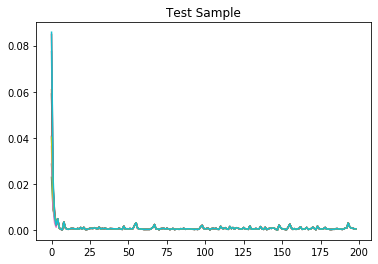

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

0.0012500533

In [ ]:
## Test on the best validation model on Full simLen

In [ ]:
# best val loss model
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

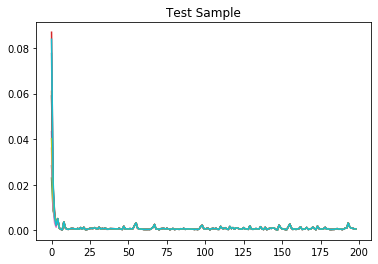

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

0.0012621909